# Analyzing the IRIS dataset with Sci-Pype

This notebook demonstrates how to use the machine learning API for automatically analyzing each column of the IRIS dataset. This notebook was built from a command-line version: 

    <repo dir>/bins/ml/demo-ml-classifier-iris.py

For those new to Jupyter here's few commands I wish I knew when I starteed:

1. Use the **h** button will open a help menu
2. Use **Shift + Enter** to run the current cell and select the one below
3. Use **Shift + Tab** when in insert mode to bring up a **live variable debugger** while the cursor is inside a word



### 1) Creating a Machine Learning API Request

The API request below is setup to analyze each column of the IRIS dataset and build + train an XGB classifier model for predictions.

In [1]:
# Setup the Sci-pype environment
import sys, os

# Only redis is needed for this notebook:
os.environ["ENV_DEPLOYMENT_TYPE"] = "JustRedis"

# Load the Sci-pype PyCore as a named-object called "core" and environment variables
from src.common.load_ipython_env import *

a) What column (**Target Column**) do you want to analyze?

In [2]:
target_column_name = "ResultTargetValue"

b) What are the possible values in that column? (**Target Column Values**)

In [3]:
target_column_values = [ "Iris-setosa", "Iris-versicolor", "Iris-virginica" ]

c) What columns can the algorithms use for training and learning? (**Feature Columnns**)

In [4]:
feature_column_names = [ "SepalLength", "SepalWidth", "PetalLength", "PetalWidth", "ResultTargetValue" ]

d) Is there a column that's a non-numeric representation of the values in the **Target Column**? (**Label Column**)

In [5]:
label_column_name = "ResultLabel"

e) Are there any columns you want to ignore from the training? (**Ignored Features** usually any non-numeric columns should be ignored)

In [6]:
ignore_features = [ # Prune non-int/float columns as needed: 
                    label_column_name
                ]

f) Select a supported Classifier Algorithm

In [7]:
ml_algo_name = "xgb-classifier"

g) Name the dataset something descriptive (this will be used as a key for caching later)

In [8]:
ds_name = "iris_classifier"

h) Assign the downloaded IRIS dataset csv file

In [9]:
# This will use <repo>/bins/ml/downloaders/download_iris.py to download this file before running
dataset_filename    = "iris.csv"
ml_csv              = str(os.getenv("ENV_DATA_SRC_DIR", "/opt/work/data/src")) + "/" + dataset_filename

# Check the file exists and download if not

if os.path.exists(ml_csv) == False:
    downloader="/opt/work/bins/ml/downloaders/download_iris.py"
    lg("Downloading and preparing(" + str(ml_csv) + ") for analysis")
    os.system(downloader)
    lg("Done Downloading and preparing(" + str(ml_csv) + ")", 5)
# end of downloading if the csv is missing

if os.path.exists(ml_csv) == False:
    downloader="/opt/work/bins/ml/downloaders/download_iris.py"
    lg("Please use the downloader: " + str(downloader) + " to download + prepare the IRIS csv file", 0)
else:
    lg("Dataset(" + str(ml_csv) + ") is ready", 5)
# end of error checking the csv file was downloaded and built

Dataset(/opt/work/data/src/iris.csv) is ready


i) Build the Machine Learning API Request dictionary

In [10]:
ml_type     = "Predict with Filter"
ml_request  = {
                "MLType"    : ml_type,
                "MLAlgo"    : {
                    "Name"      : ml_algo_name,
                    "Version"   : 1,
                    "Meta"      : {
                        "UnitsAhead"    : 0,
                        "DatasetName"   : ds_name,
                        "FilterMask"    : None,
                        "Source"        : {
                            "CSVFile"       : ml_csv,
                            "S3File"        : "",        # <Bucket Name>:<Key>
                            "RedisKey"      : ""         # <App Name>:<Key>
                        },
                    },
                    "Steps"     : {
                        "Train"     :{              # these are specific for building an XGB Classifier
                            "LearningRate"          : 0.1,
                            "NumEstimators"         : 1000,
                            "Objective"             : "reg:linear",
                            "MaxDepth"              : 6,
                            "MaxDeltaStep"          : 0,
                            "MinChildWeight"        : 1,
                            "Gamma"                 : 0,
                            "SubSample"             : 0.8,
                            "ColSampleByTree"       : 0.8,
                            "ColSampleByLevel"      : 1.0,
                            "RegAlpha"              : 0,
                            "RegLambda"             : 1,
                            "BaseScore"             : 0.5,
                            "NumThreads"            : -1, # infinite = -1
                            "ScaledPositionWeight"  : 1,
                            "Seed"                  : 27,
                            "Debug"                 : True
                        }
                    }
                },
                "FeatureColumnNames": feature_column_names,
                "TargetColumnName"  : target_column_name,
                "TargetColumnValues": target_column_values,
                "IgnoreFeatures"    : ignore_features,
                "UnitsAheadSet"     : [],
                "UnitsAheadType"    : "",
                "PredictionType"    : "Predict",
                "MaxFeatures"       : 10,
                "Version"           : 1,
                "TrackingType"      : "UseTargetColAndUnits",
                "TrackingName"      : core.to_upper(ds_name),
                "TrackingID"        : "ML_" + ds_name + "_" + str(core.build_unique_key()),
                "Debug"             : False
            }

j) Validate the dataset is ready for use

Loading CSV(/opt/work/data/src/iris.csv)
Samples(150) in CSV(/opt/work/data/src/iris.csv)

       SepalLength  SepalWidth  PetalLength  PetalWidth  ResultTargetValue
count   150.000000  150.000000   150.000000  150.000000         150.000000
mean      5.843333    3.054000     3.758667    1.198667           1.000000
std       0.828066    0.433594     1.764420    0.763161           0.819232
min       4.300000    2.000000     1.000000    0.100000           0.000000
25%       5.100000    2.800000     1.600000    0.300000           0.000000
50%       5.800000    3.000000     4.350000    1.300000           1.000000
75%       6.400000    3.300000     5.100000    1.800000           2.000000
max       7.900000    4.400000     6.900000    2.500000           2.000000

ResultLabel
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

Plotting Validation Pair Plot - Please wait a moment...


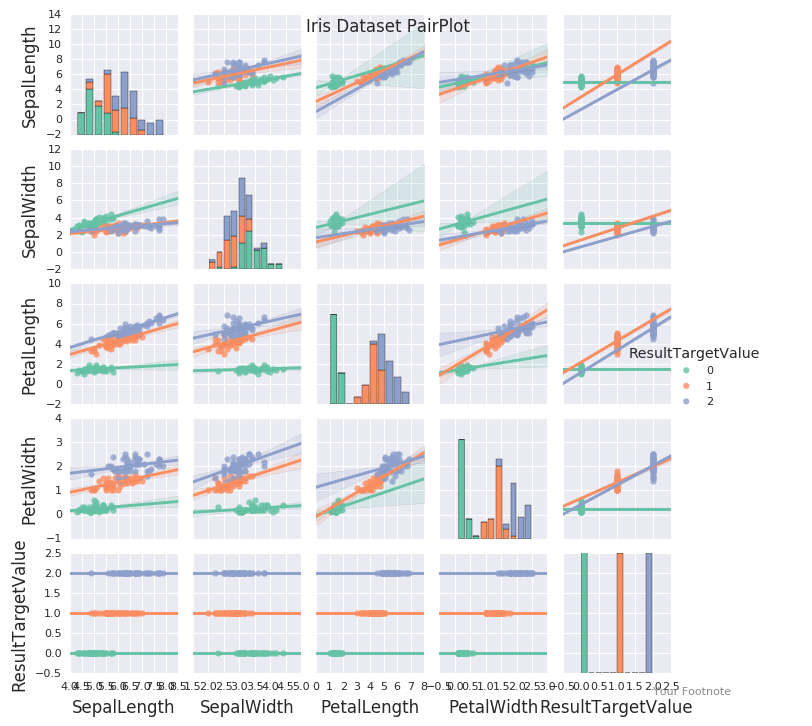

Done Plotting Valiation Pair Plot - Saved(/opt/work/data/src/validate_jupyter_iris_classification_pairplot.png)


In [11]:
# Load the dataset
csv_res             = core.ml_load_csv_dataset(ml_request, core.get_rds(), core.get_dbs(), debug)
if csv_res["Status"] != "SUCCESS":
    lg("ERROR: Failed to Load CSV(" + str(ml_request["MLAlgo"]["Meta"]["Source"]["CSVFile"]) + ")", 0)
    sys.exit(1)

# Assign a local variable to build a sample record mask:
ds_df               = csv_res["Record"]["SourceDF"]

# Build a filter record mask for pruning bad records out before creating the train/test sets
samples_filter_mask =    (ds_df["SepalLength"] > 0.0) \
                       & (ds_df["PetalWidth"]  > 0.0)

# For patching on the fly you can use the encoder method to replace labels with target dictionary values:
#ds_df                = core.ml_encode_target_column(ds_df, "ResultLabel", "Target")

# Add the filter mask to the request for changing the train/test samples in the dataset:
ml_request["MLAlgo"]["Meta"]["SamplesFilterMask"]  = samples_filter_mask

show_pair_plot      = True
if show_pair_plot:
    lg("Samples(" + str(len(ds_df.index)) + ") in CSV(" + str(ml_request["MLAlgo"]["Meta"]["Source"]["CSVFile"]) + ")", 6)
    lg("")
    print ds_df.describe()
    lg("")
    num_per_class   = ds_df.groupby("ResultLabel").size()
    print num_per_class
    lg("")

    pair_plot_req   = {
                    "Title"         : "Iris Dataset PairPlot",
                    "SourceDF"      : ds_df[samples_filter_mask],
                    "Style"         : "default",
                    "DiagKind"      : "hist", # "kde" or "hist"
                    "HueColumnName" : ml_request["TargetColumnName"],
                    "XLabel"        : "",
                    "YLabel"        : "",
                    "CompareColumns": ml_request["FeatureColumnNames"],
                    "Size"          : 3.0,
                    "ImgFile"       : str(os.getenv("ENV_DATA_SRC_DIR", "/opt/work/data/src")) + "/" + "validate_jupyter_iris_classification_pairplot.png",
                    "ShowPlot"      : True
                  }
    
    lg("Plotting Validation Pair Plot - Please wait a moment...", 6)
    core.sb_pairplot(pair_plot_req)
    if os.path.exists(pair_plot_req["ImgFile"]):
        lg("Done Plotting Valiation Pair Plot - Saved(" + str(pair_plot_req["ImgFile"]) + ")", 5)
    else:
        lg("Failed to save Validation Pair Plot(" + str(pair_plot_req["ImgFile"]) + "). Please check the ENV_DATA_SRC_DIR is writeable by this user and exposed to the docker container correctly.", 0)
# end of showing a pairplot for validation

### 2) Build and Train Algorithm Models

The ``ml_train_models_for_predictions`` method creates a list of algorithm models based off the API request and trains them.

In [12]:
ml_images               = []
train_results           = core.ml_train_models_for_predictions(ml_request, core.get_rds(), core.get_dbs(), debug)
if train_results["Status"] != "SUCCESS":
    lg("ERROR: Failed to Train Models for Predictions with Error(" + str(train_results["Error"]) + ") StoppedEarly(" + str(train_results["Record"]["StoppedEarly"]) + ")", 0)
else:
    lg("Done Training Algos", 5)

Build Processing(0/5) Algo(SepalLength)
Loading CSV(/opt/work/data/src/iris.csv)
Counting Samples from Mask
Counting Predictions from Mask
Done Counting Samples(149) Predictions(150)
Building predictors
Predictors(4) Building XGB Classifier
Training Classifier
Getting XGB Params
Building DMatrix for Target(SepalLength)
Fitting XGB - Features(4) TargetColumn(SepalLength) Train(83) Test(66) Target Train(83) Test(66)


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Predicting Values
Building Accuracy
Predictions(66) Max(7.7) Min(4.4) AUROC(None) Rankings(0)
Building ConfusionMatrix
Build - Done Processing(1/5) Algo(SepalLength)
Build Processing(1/5) Algo(SepalWidth)
Loading CSV(/opt/work/data/src/iris.csv)
Counting Samples from Mask
Counting Predictions from Mask
Done Counting Samples(149) Predictions(150)
Building predictors
Predictors(4) Building XGB Classifier
Training Classifier
Getting XGB Params
Building DMatrix for Target(SepalWidth)
Fitting XGB - Features(4) TargetColumn(SepalWidth) Train(83) Test(66) Target Train(83) Test(66)
Predicting Values
Building Accuracy
Predictions(66) Max(4.0) Min(2.4) AUROC(None) Rankings(0)
Building ConfusionMatrix
Build - Done Processing(2/5) Algo(SepalWidth)
Build Processing(2/5) Algo(PetalLength)
Loading CSV(/opt/work/data/src/iris.csv)
Counting Samples from Mask
Counting Predictions from Mask
Done Counting Samples(149) Predictions(150)
Building predictors
Predictors(4) Building XGB Classifier
Training Clas

### 3) Predictions

The ``ml_compile_predictions_from_models`` method will iterate over the list of algorithm models and make predictions based off the ``predict_row`` dictionary.   

In [13]:
algo_nodes      = train_results["Record"]["AlgoNodes"]
predict_row     = {
                    "SepalLength"       : 5.4,
                    "SepalWidth"        : 3.4,
                    "PetalLength"       : 1.7,
                    "PetalWidth"        : 0.2,
                    "ResultTargetValue" : 0
                }

predict_row_df  = pd.DataFrame(predict_row, index=[0])
predict_req     = {
                    "AlgoNodes"     : algo_nodes,
                    "PredictionMask": samples_filter_mask,
                    "PredictionRow" : predict_row_df
                }
predict_results = core.ml_compile_predictions_from_models(predict_req, core.get_rds(), core.get_dbs(), debug)
if predict_results["Status"] != "SUCCESS":
    lg("ERROR: Failed to Compile Predictions from Models with Error(" + str(predict_results["Error"]) + ")", 0)
else:
    lg("Done with Predictions", 5)

Compiling Predictions for AlgoNodes(5)
Algo(1/5) Predicting TargetColumnName(SepalLength)
Determine Model Prediction
Algo(2/5) Predicting TargetColumnName(SepalWidth)
Determine Model Prediction
Algo(3/5) Predicting TargetColumnName(PetalLength)
Determine Model Prediction
Algo(4/5) Predicting TargetColumnName(PetalWidth)
Determine Model Prediction
Algo(5/5) Predicting TargetColumnName(ResultTargetValue)
Determine Model Prediction
Done with Predictions


### 4) Analysis

The ``ml_compile_analysis_dataset`` method will create a dictionary of analysis datasets based off the Target Column they are predicting.

In [14]:
al_req           = train_results["Record"]

al_req["DSName"]            = ml_request["TrackingName"]
al_req["Version"]           = 1
al_req["FeatureColumnNames"]= ml_request["FeatureColumnNames"]
al_req["TargetColumnName"]  = ml_request["TargetColumnName"]
al_req["TargetColumnValues"]= ml_request["TargetColumnValues"]
al_req["IgnoreFeatures"]    = ml_request["IgnoreFeatures"]
al_req["PredictionType"]    = ml_request["PredictionType"]
al_req["ConfMatrices"]      = predict_results["Record"]["ConfMatrices"]
al_req["PredictionMarkers"] = predict_results["Record"]["PredictionMarkers"]

analysis_dataset = core.ml_compile_analysis_dataset(al_req, core.get_rds(), core.get_dbs(), debug)

lg("Analyzed Models(" + str(len(analysis_dataset["Models"])) + ")", 5)

Analyzed Models(5)


### 5) Caching

The ``ml_cache_analysis_and_models`` method will cache each algorithm model with the analysis dataset in the redis instance named "**Cache**" listening on port 6000.

In [15]:
lg("Caching Models", 6)

cache_req     = {
                "Name"      : "CACHE",
                "Key"       : "_MODELS_" + str(al_req["Tracking"]["TrackingName"]) + "_LATEST",
                "TrackingID": "_MD_" + str(al_req["Tracking"]["TrackingName"]),
                "Analysis"  : analysis_dataset
              }

cache_results = core.ml_cache_analysis_and_models(cache_req, core.get_rds(), core.get_dbs(), debug)

lg("Done Caching Models", 5)

Caching Models
Compressing Models(5)
Compressing Model(0/5) Type(XGBClassifier)
Done Compressing(0/5) Type(XGBClassifier) Size(1158191) Decompressed(7229771)
Caching Model(0) ID(_MD_IRIS_CLASSIFIER_bf9214_0) RLoc(CACHE:_MD_IRIS_CLASSIFIER_SepalLength)
Done Caching Model(0) ID(_MD_IRIS_CLASSIFIER_bf9214_0) RLoc(CACHE:_MODELS_IRIS_CLASSIFIER_LATEST)
Compressing Model(1/5) Type(XGBClassifier)
Done Compressing(1/5) Type(XGBClassifier) Size(1238867) Decompressed(8668378)
Caching Model(1) ID(_MD_IRIS_CLASSIFIER_bf9214_1) RLoc(CACHE:_MD_IRIS_CLASSIFIER_PetalLength)
Done Caching Model(1) ID(_MD_IRIS_CLASSIFIER_bf9214_1) RLoc(CACHE:_MODELS_IRIS_CLASSIFIER_LATEST)
Compressing Model(2/5) Type(XGBClassifier)
Done Compressing(2/5) Type(XGBClassifier) Size(821021) Decompressed(4789674)
Caching Model(2) ID(_MD_IRIS_CLASSIFIER_bf9214_2) RLoc(CACHE:_MD_IRIS_CLASSIFIER_PetalWidth)
Done Caching Model(2) ID(_MD_IRIS_CLASSIFIER_bf9214_2) RLoc(CACHE:_MODELS_IRIS_CLASSIFIER_LATEST)
Compressing Model(3/5) Typ

### 6) Visualizations

There is a simple plotting request API for quickly creating visuals based off the the type of analysis and the underlying model.

a) Set common plot settings

In [16]:
# Turn this False to show the images:
analysis_dataset["ShowPlot"] = True
analysis_dataset["SourceDF"] = al_req["SourceDF"]

b) Plot Feature Importance

Plotting Feature Importance


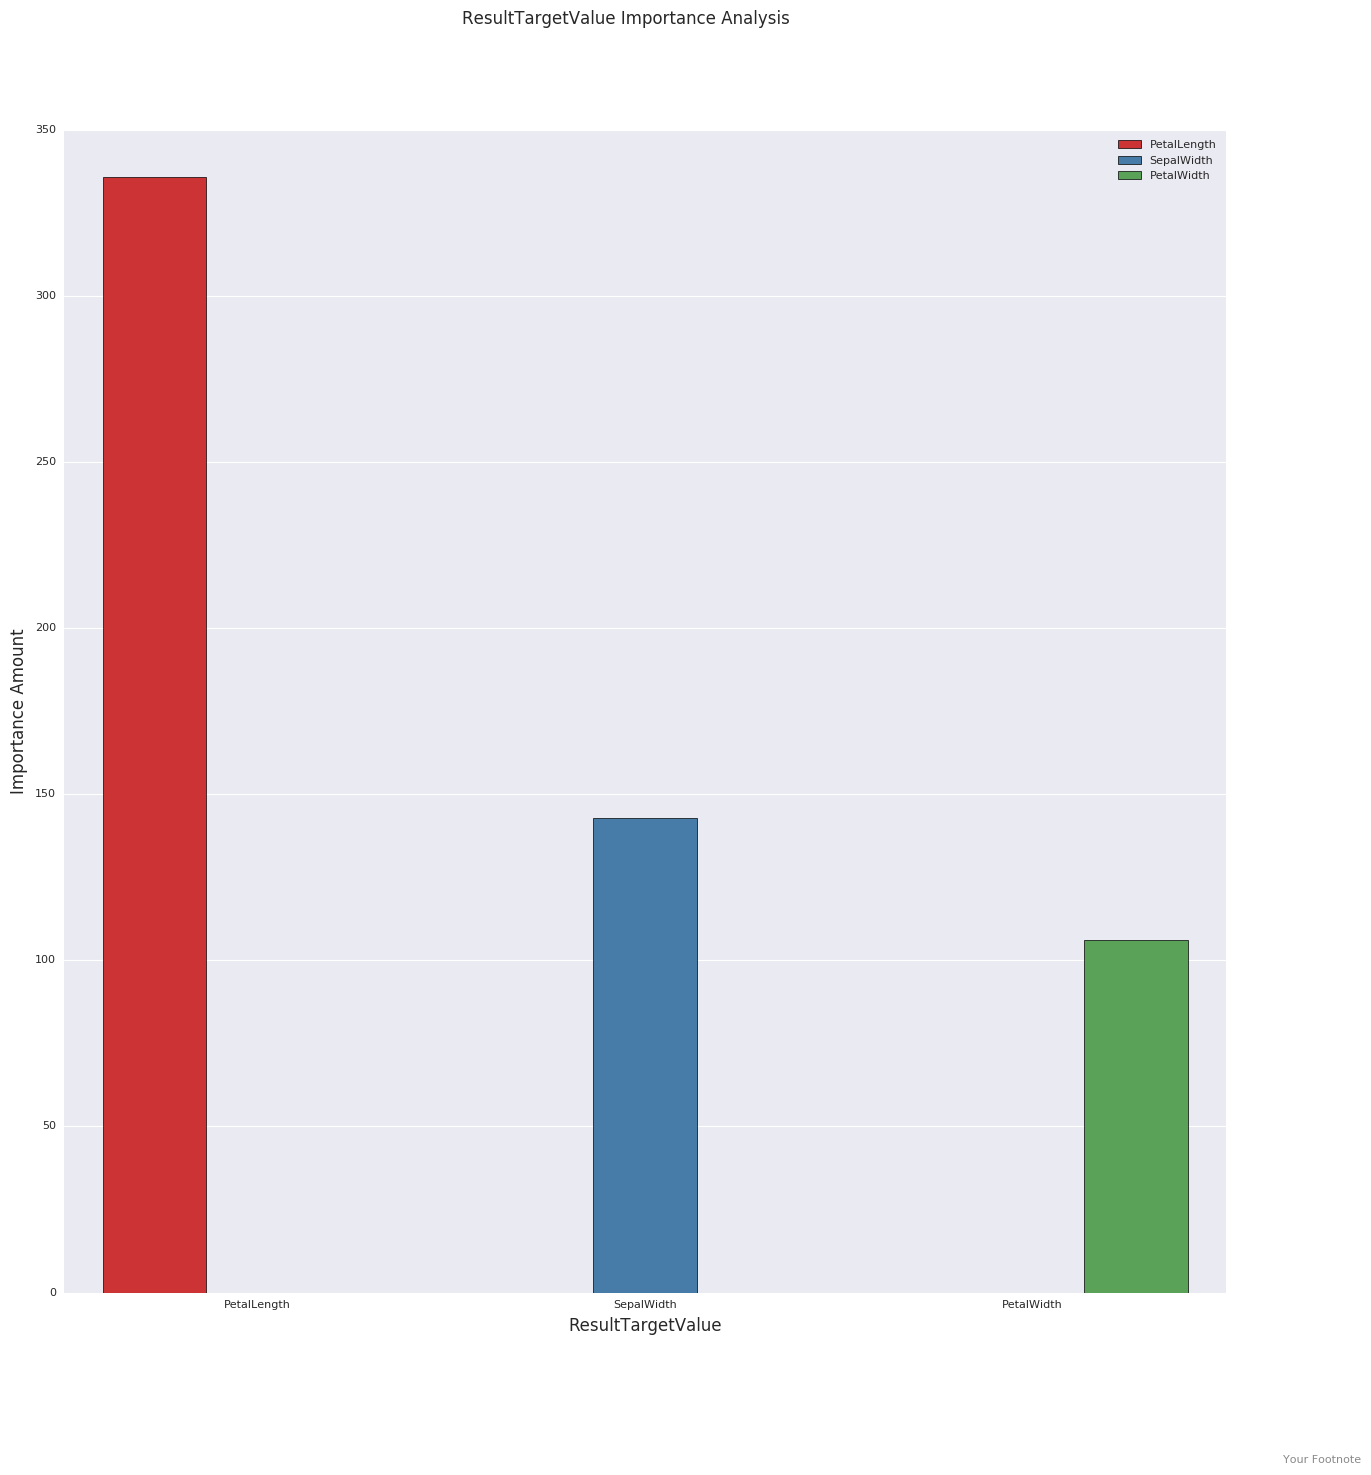

In [17]:
lg("Plotting Feature Importance", 6)

for midx,model_node in enumerate(analysis_dataset["Models"]):
    predict_col     = model_node["Target"]
    if predict_col == "ResultTargetValue":
        plot_req    = {
                        "ImgFile"   : analysis_dataset["FeatImpImgFile"],
                        "Model"     : model_node["Model"],
                        "XLabel"    : str(predict_col),
                        "YLabel"    : "Importance Amount",
                        "Title"     : str(predict_col) + " Importance Analysis",
                        "ShowPlot"  : analysis_dataset["ShowPlot"]
                    }
        image_list  = core.sb_model_feature_importance(plot_req, debug)
        for img in image_list:
            ml_images.append(img)
# end of for all models

c) Show Pair Plot

Plotting PairPlot


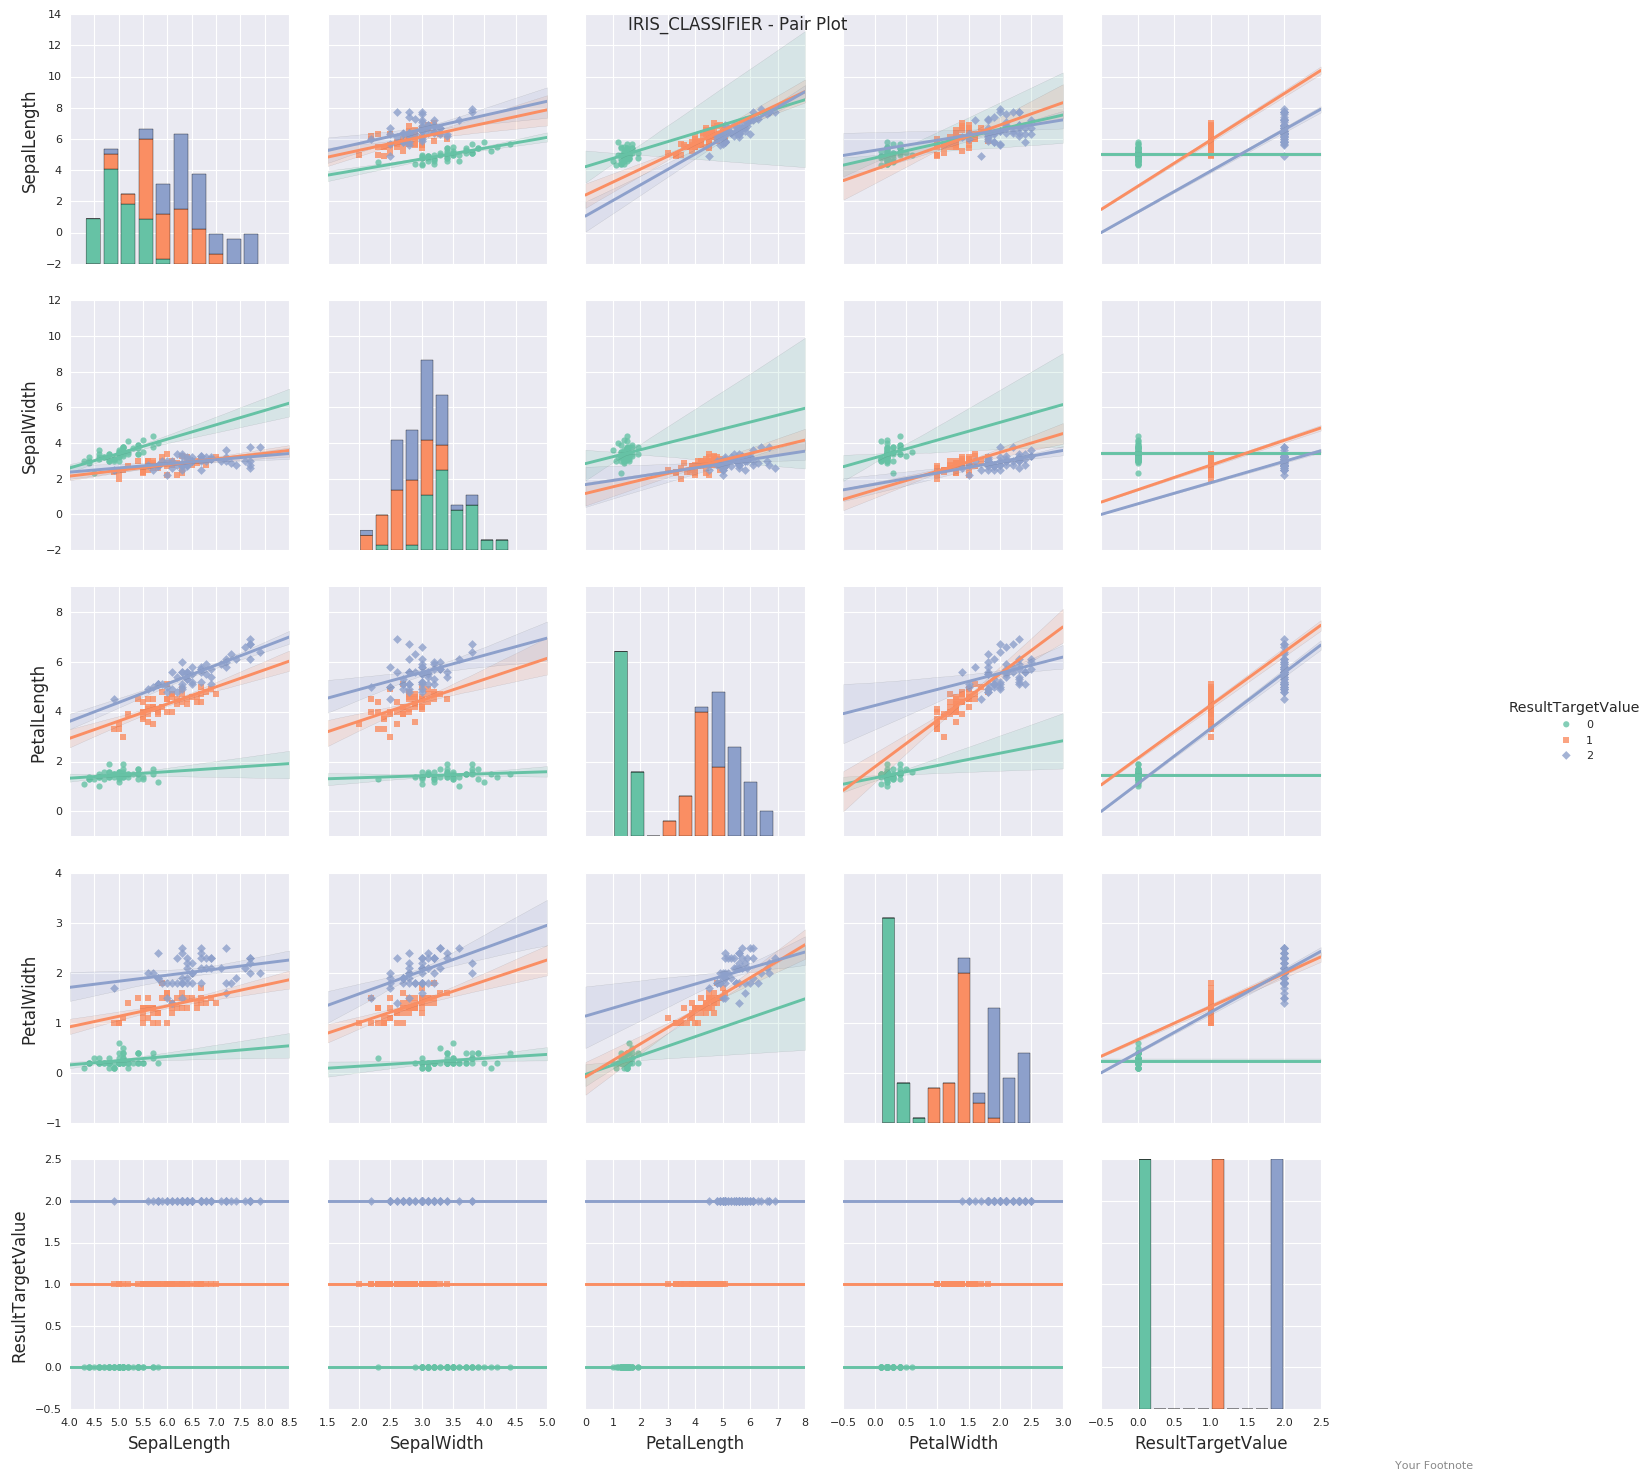

In [18]:
lg("Plotting PairPlot", 6)

plot_req  = {
             "DSName"        : str(analysis_dataset["DSName"]),
             "Title"         : str(analysis_dataset["DSName"]) + " - Pair Plot",
             "ImgFile"       : str(analysis_dataset["PairPlotImgFile"]),
             "SourceDF"      : al_req["SourceDF"],
             "HueColumnName" : target_column_name,
             "CompareColumns": feature_column_names,
             "Markers"       : ["o", "s", "D"],
             "Width"         : 15.0,
             "Height"        : 15.0,
             "ShowPlot"      : analysis_dataset["ShowPlot"]
           }

image_list = core.sb_pairplot(plot_req, debug)
for img in image_list:
    ml_images.append(img)

d) Show Confusion Matrix

Plotting Confusion Matrices


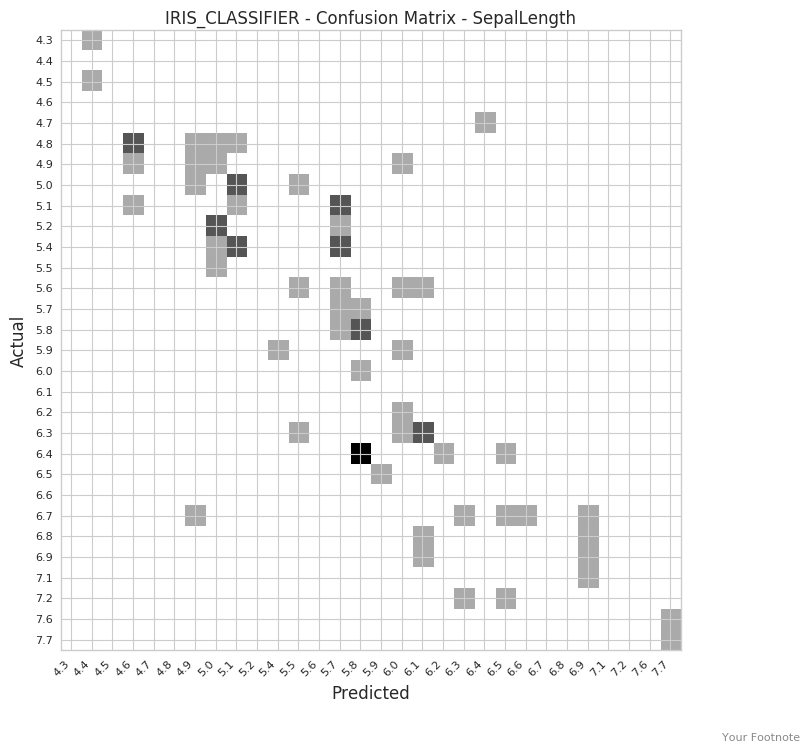

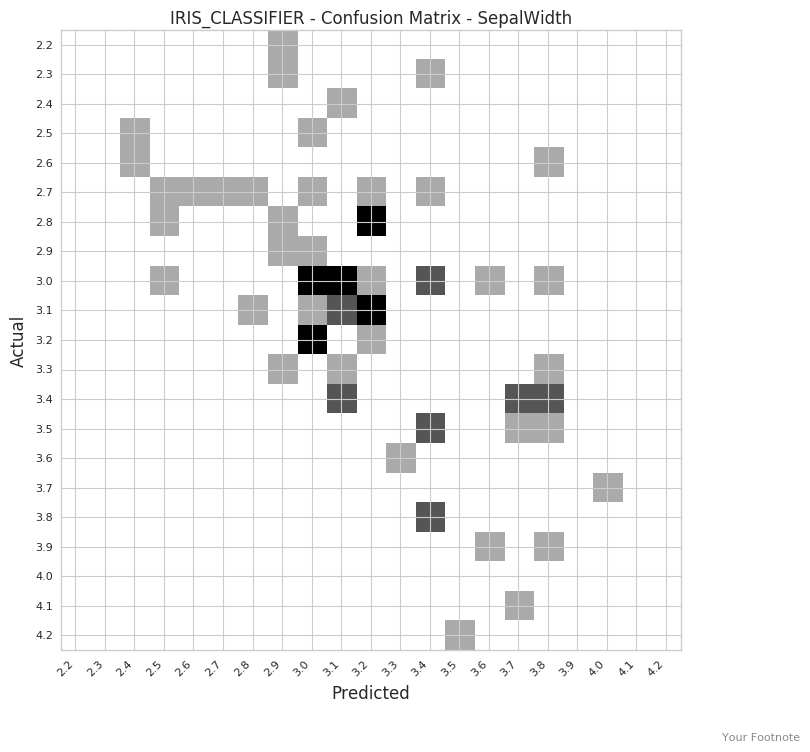

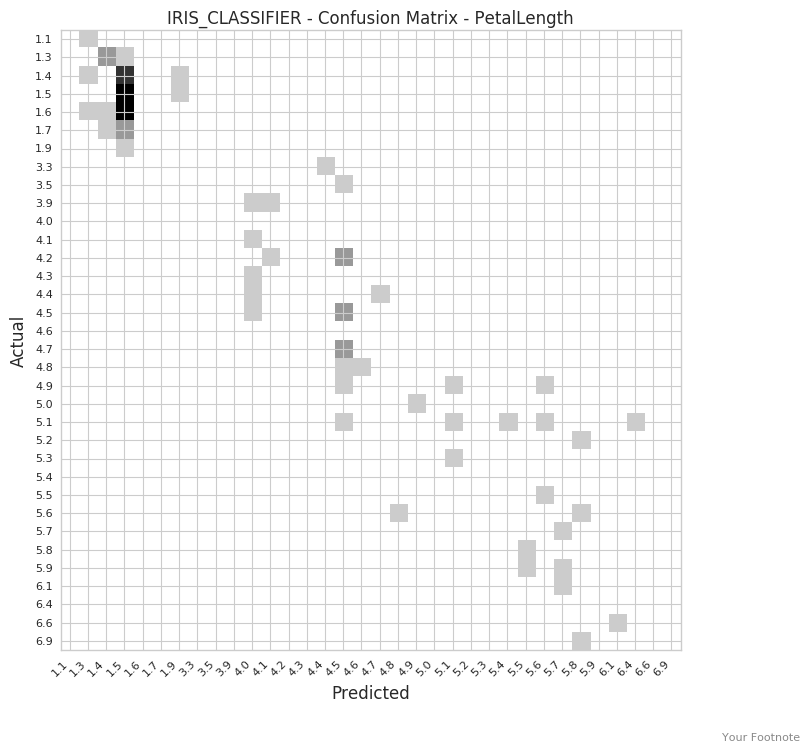

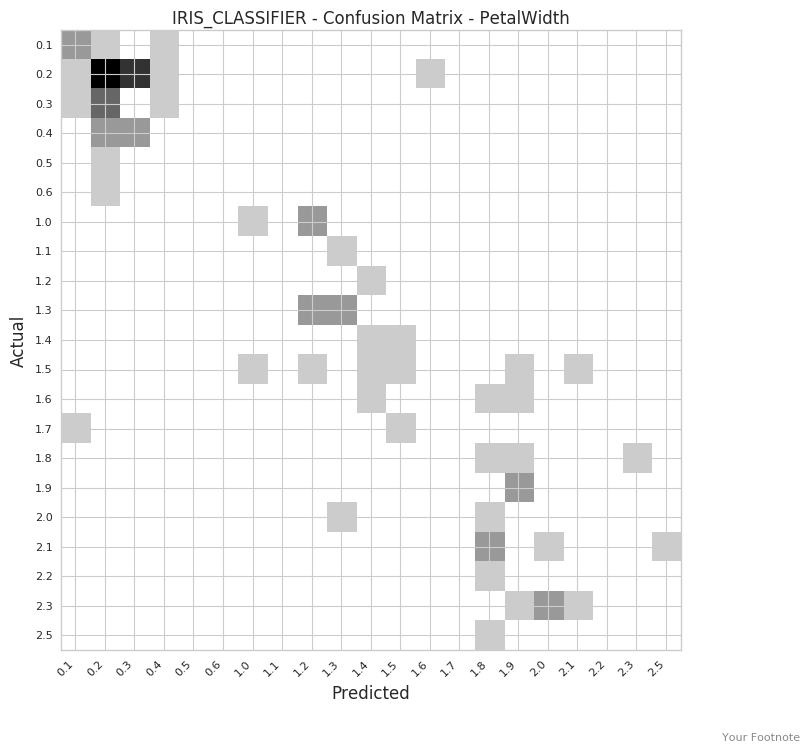

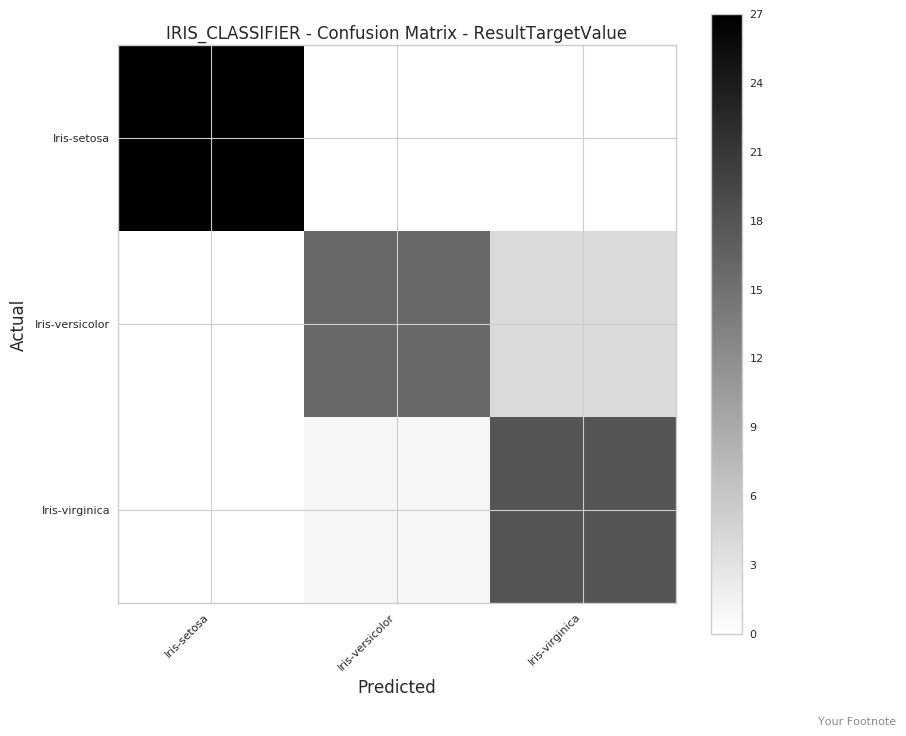

In [19]:
lg("Plotting Confusion Matrices", 6)

plot_req   = {
              "DSName"        : str(analysis_dataset["DSName"]),
              "Title"         : str(analysis_dataset["DSName"]) + " - Confusion Matrix",
              "ImgFile"       : str(analysis_dataset["CMatrixImgFile"]),
              "SourceDF"      : al_req["SourceDF"],
              "ConfMatrices"  : al_req["ConfMatrices"],
              "Width"         : 15.0,
              "Height"        : 15.0,
              "XLabel"        : "Dates",
              "YLabel"        : "Values",
              "ShowPlot"      : analysis_dataset["ShowPlot"]
            }

image_list  = core.sb_confusion_matrix(plot_req, debug)
for img in image_list:
    ml_images.append(img)

e) Show Scatter Plots

Plotting Scatters


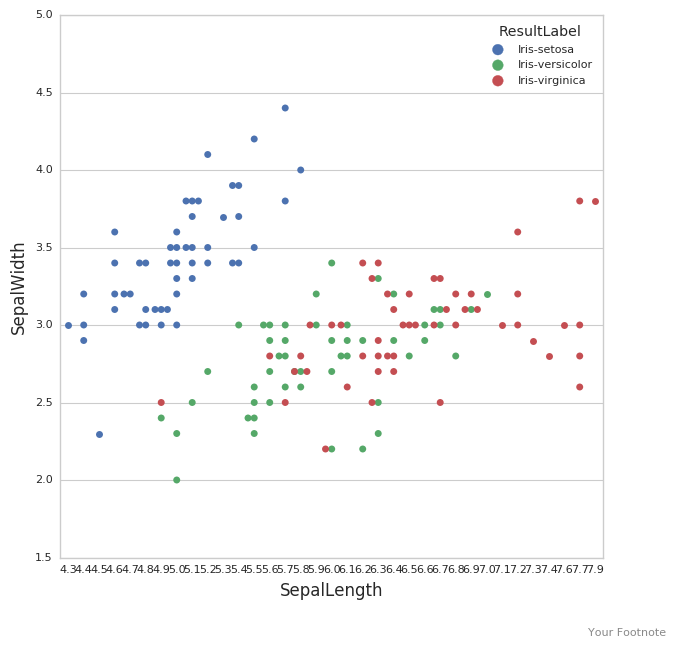

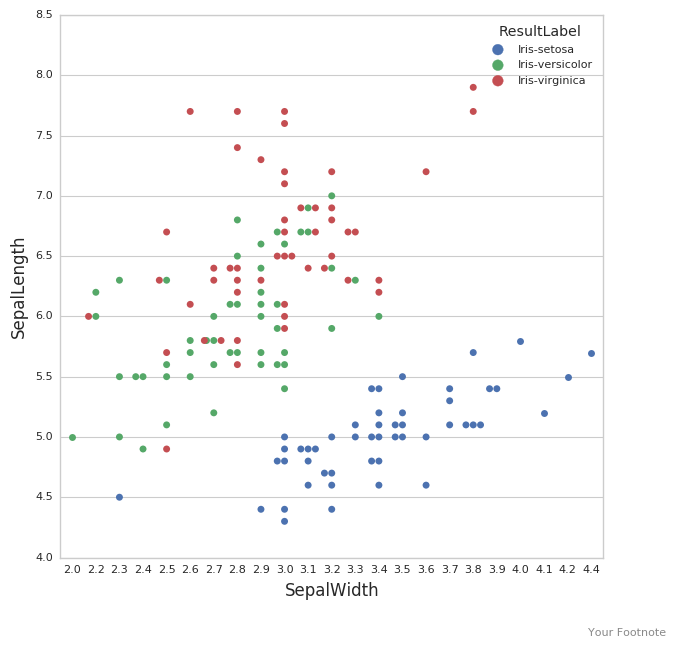

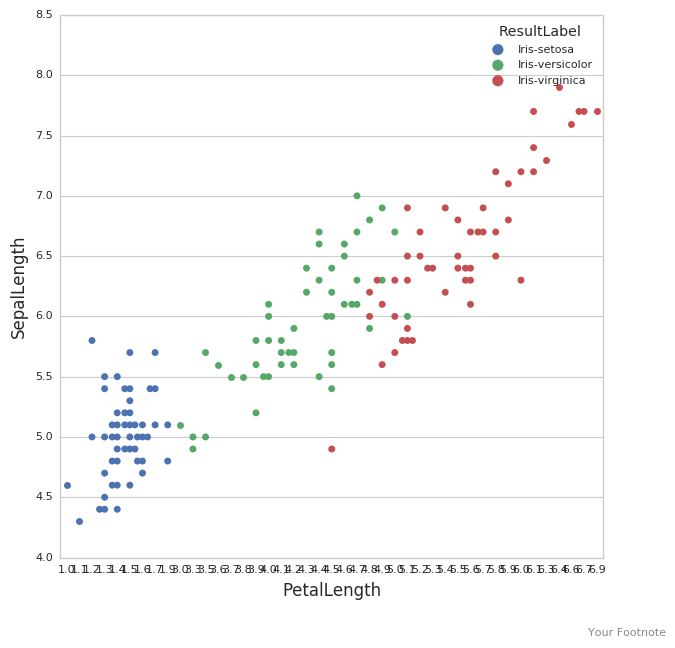

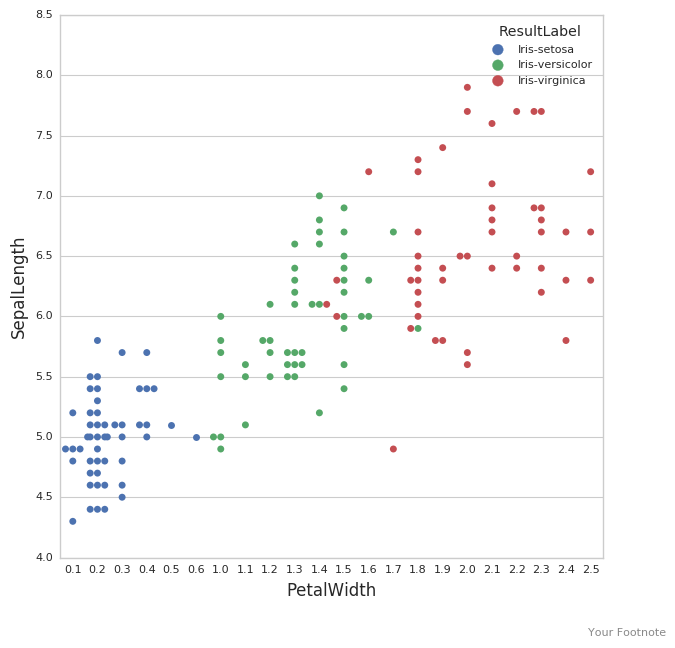

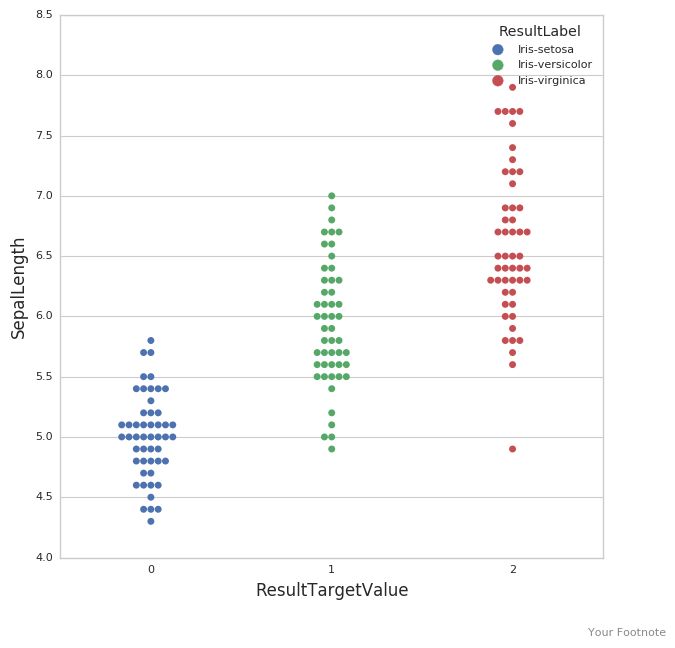

In [20]:
lg("Plotting Scatters", 6)

plot_req = {
            "DSName"            : str(analysis_dataset["DSName"]),
            "Title"             : str(analysis_dataset["DSName"]) + " - Scatter Plot",
            "ImgFile"           : str(analysis_dataset["ScatterImgFile"]),
            "SourceDF"          : analysis_dataset["SourceDF"],
            "UnitsAheadType"    : analysis_dataset["UnitsAheadType"],
            "FeatureColumnNames": analysis_dataset["FeatureColumnNames"],
            "Hue"               : label_column_name,
            "Width"             : 7.0,
            "Height"            : 7.0,
            "XLabel"            : "Dates",
            "YLabel"            : "Values",
            "ShowPlot"          : analysis_dataset["ShowPlot"]
        }

image_list = core.sb_all_scatterplots(plot_req, debug)
for img in image_list:
    ml_images.append(img)

f) Show Joint Plots

Plotting JointPlots


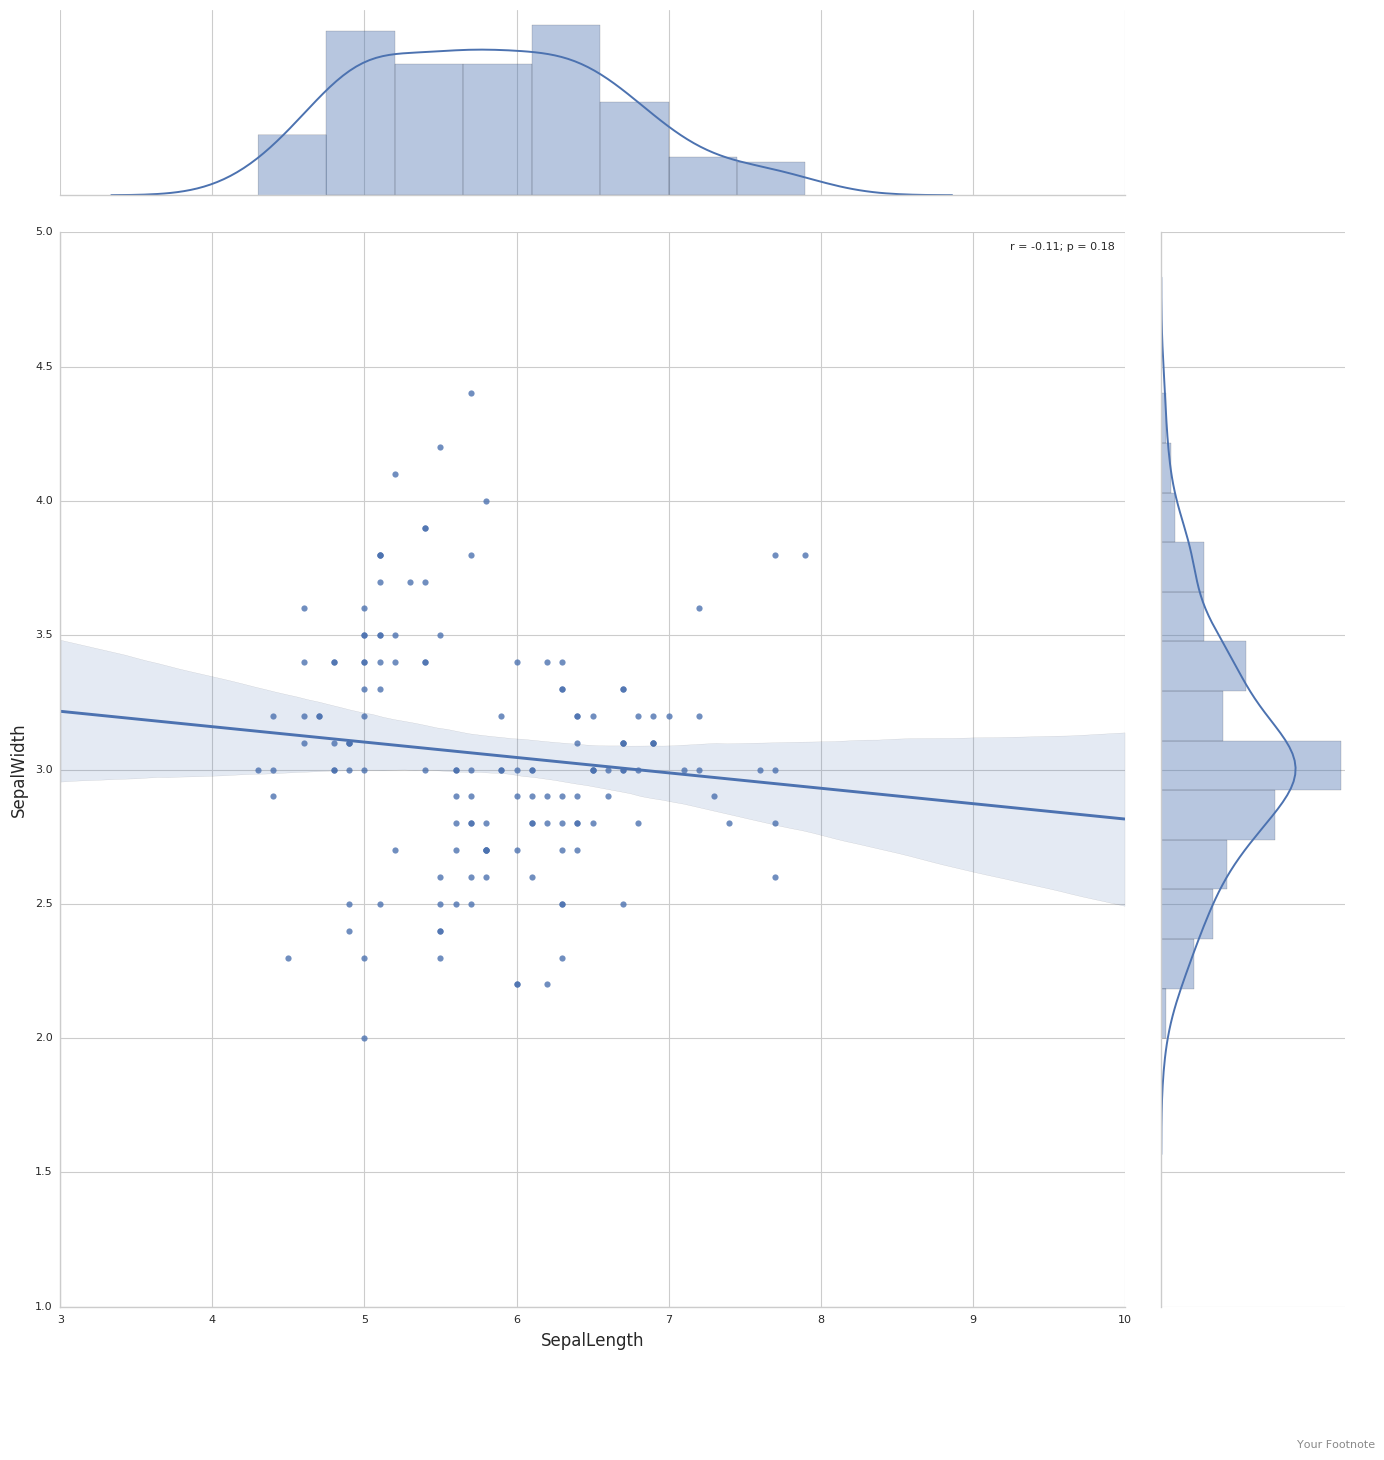

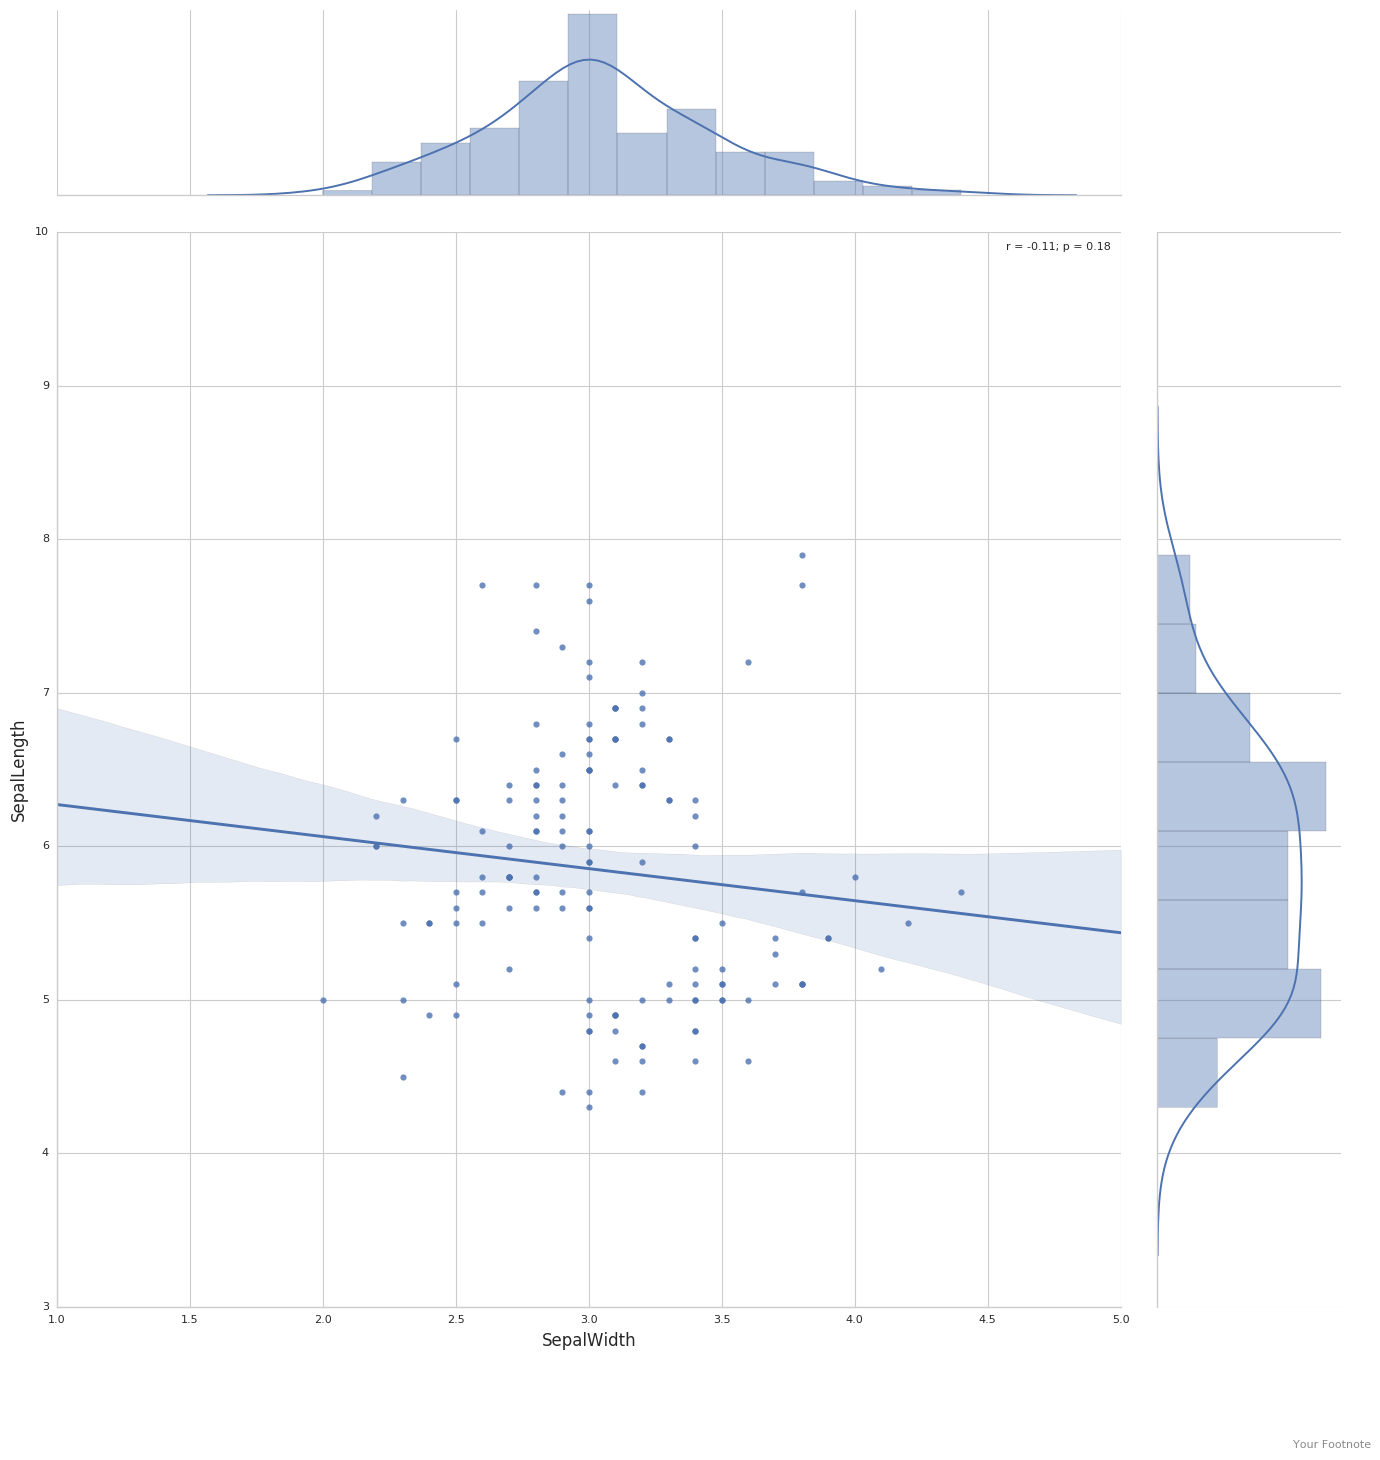

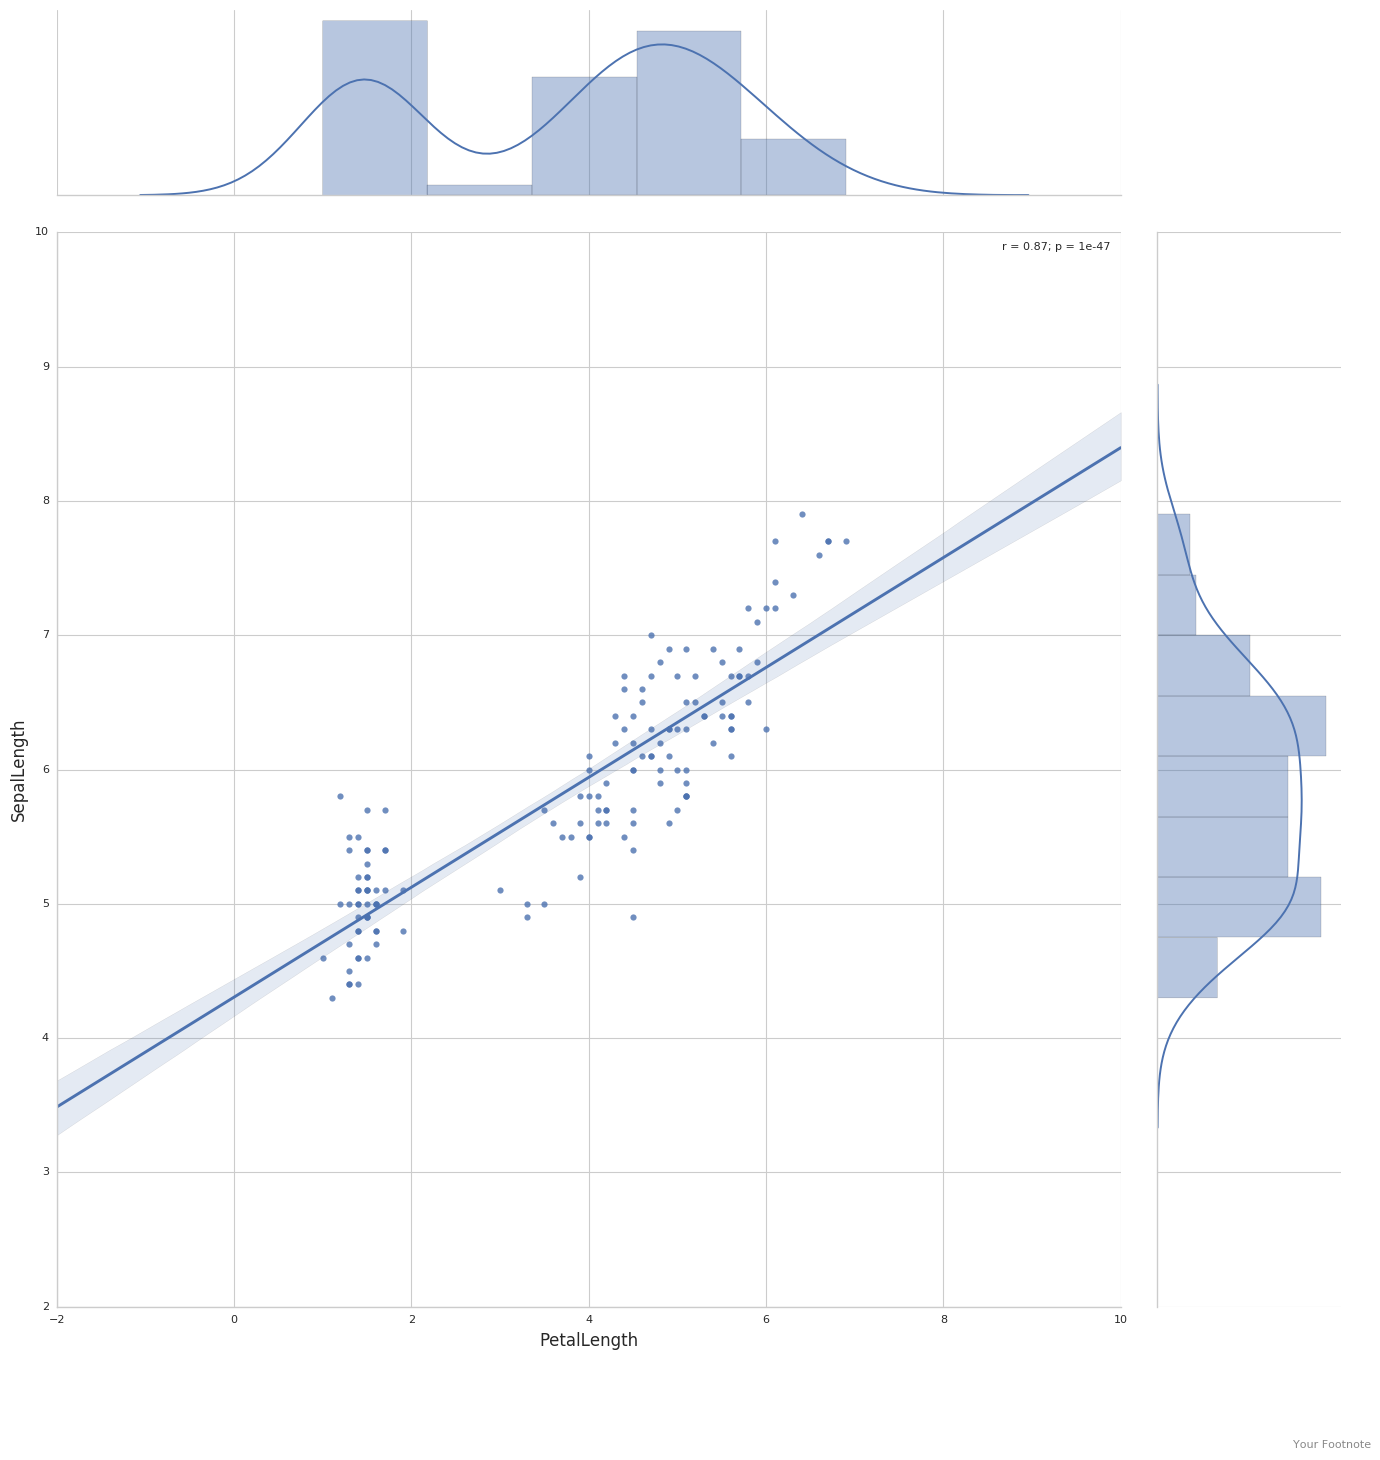

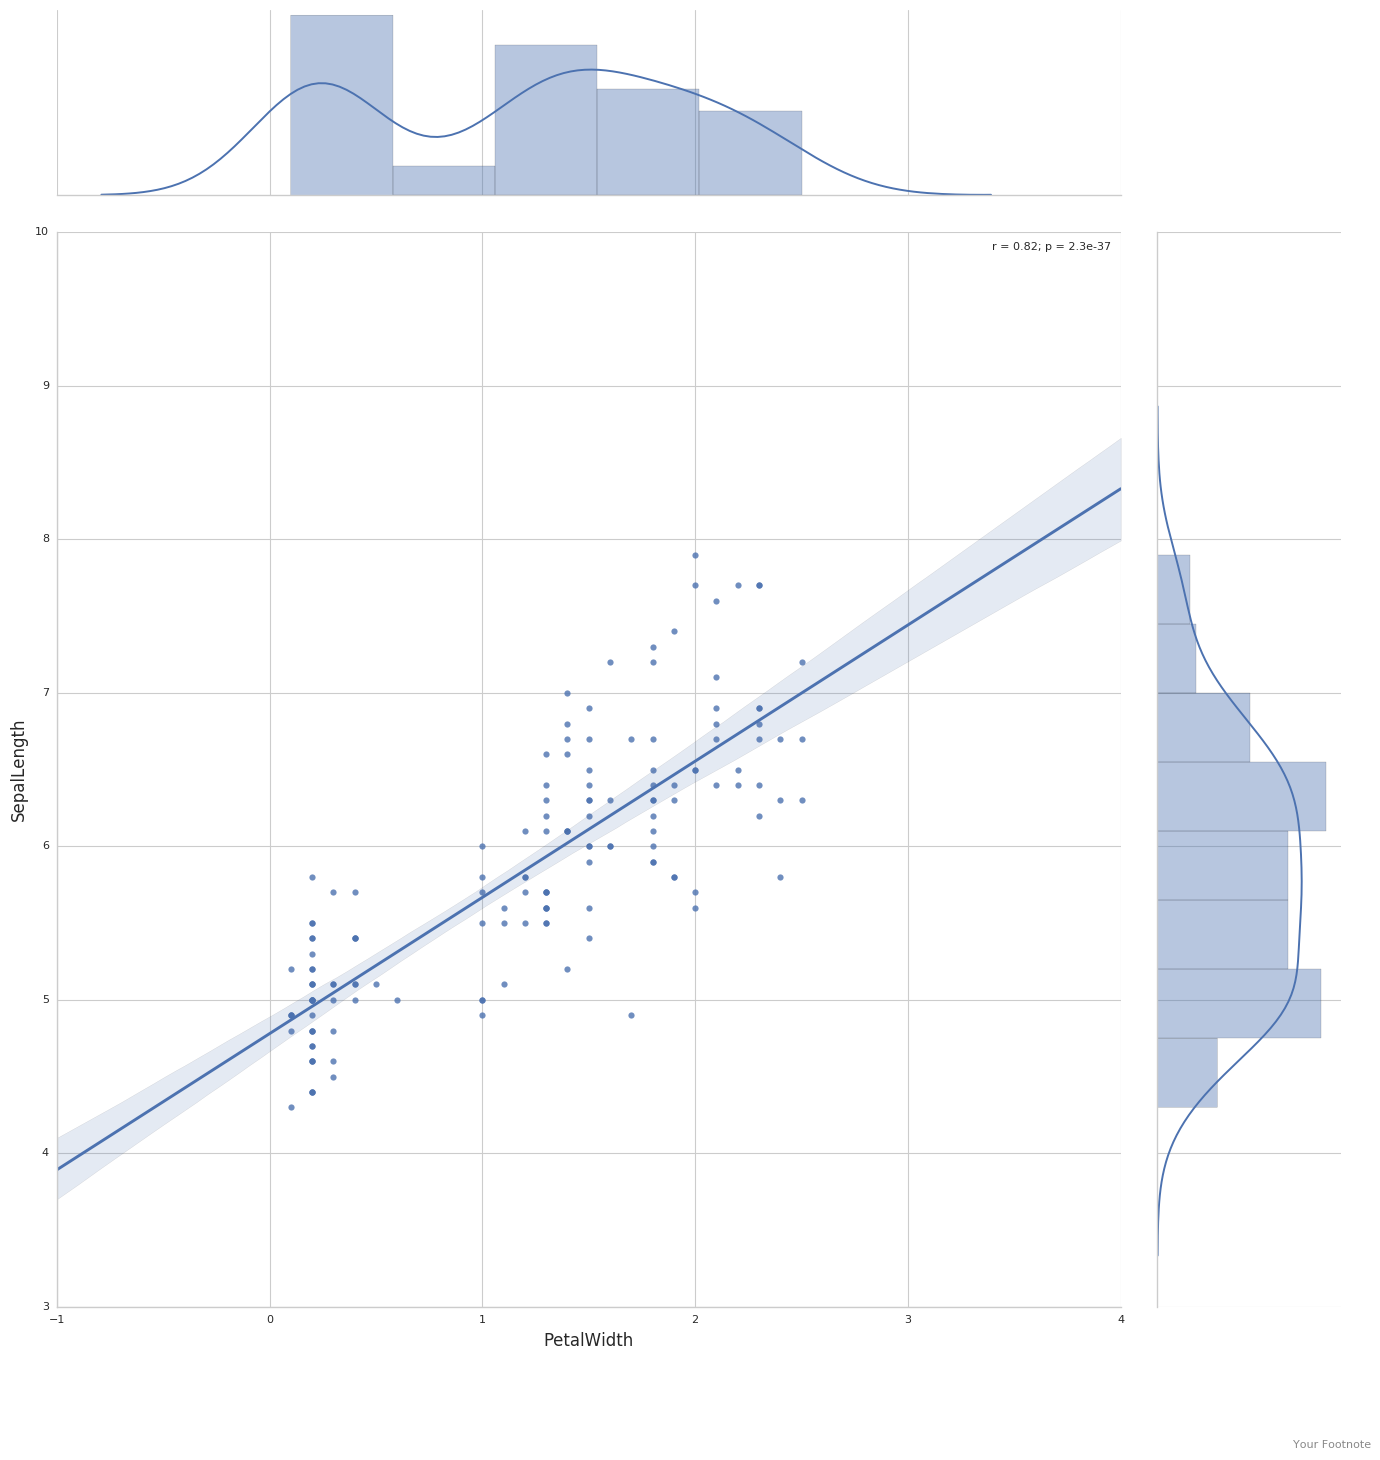

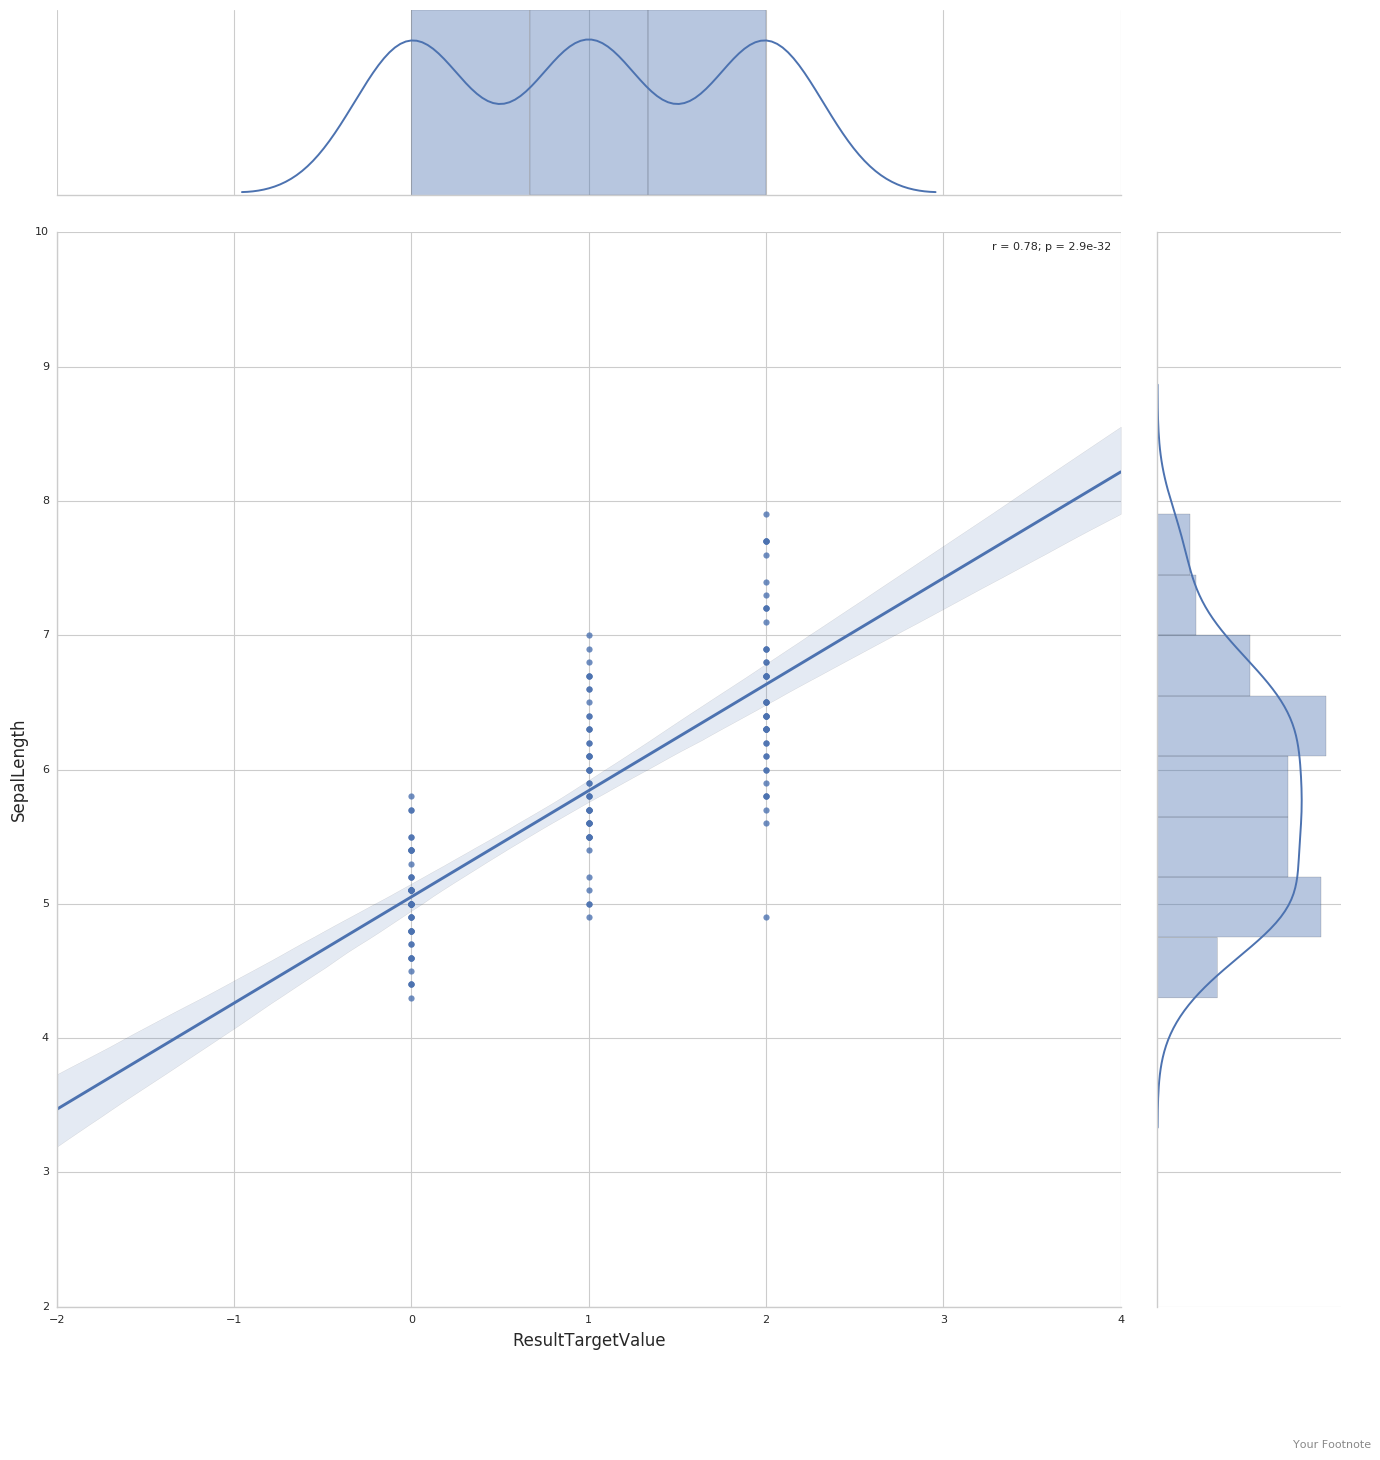


Analysis Complete Saved Images(17)



In [21]:
lg("Plotting JointPlots", 6)

plot_req = {
             "DSName"            : str(analysis_dataset["DSName"]),
             "Title"             : str(analysis_dataset["DSName"]) + " - Joint Plot",
             "ImgFile"           : str(analysis_dataset["JointPlotImgFile"]),
             "SourceDF"          : analysis_dataset["SourceDF"],
             "UnitsAheadType"    : analysis_dataset["UnitsAheadType"],
             "FeatureColumnNames": analysis_dataset["FeatureColumnNames"],
             "Hue"               : label_column_name,
             "Width"             : 15.0,
             "Height"            : 15.0,
             "XLabel"            : "Dates",
             "YLabel"            : "Values",
             "ShowPlot"          : analysis_dataset["ShowPlot"]
          }

image_list = core.sb_all_jointplots(plot_req, debug)
for img in image_list:
    ml_images.append(img)
    
lg("", 6)
lg("Analysis Complete Saved Images(" + str(len(ml_images)) + ")", 5)
lg("", 6)

### Automation with Lambda - Coming Soon

Native lambda uploading support will be added in the future. Packaging and functionality still need to be figured out. For now, you can extend the command line versions for the predictors below.

#### Command-line Versions

I built this notebook from the demo examples:

https://github.com/jay-johnson/sci-pype/tree/master/release/bins/ml/

And builders for the command line that do not show any plots, but still perform the Train/Fit/Test + Analysis:

https://github.com/jay-johnson/sci-pype/tree/master/release/bins/ml/builders